# Here we try a variety of probes

They all fit into a sklearn style api, except they take torch tensors of >2 dims


In [1]:
import os
os.environ['TQDM_DISABLE'] = '1'


In [2]:
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from tqdm.auto import tqdm

plt.style.use("ggplot")

from typing import Optional, List, Dict, Union
from jaxtyping import Float
from torch import Tensor

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch import Tensor
from torch import optim
from torch.utils.data import random_split, DataLoader, TensorDataset

from pathlib import Path
from einops import rearrange


import datasets
from datasets import Dataset

from loguru import logger


from typing import Optional, List, Dict, Union, Tuple
from jaxtyping import Float
from torch import Tensor

logger.add(os.sys.stderr, format="{time} {level} {message}", level="INFO")

# # quiet please
torch.set_float32_matmul_precision("medium")
import warnings
warnings.filterwarnings("ignore", ".*does not have many workers.*")


In [3]:
# load my code
%load_ext autoreload
%autoreload 2

import lightning.pytorch as pl
from src.datasets.dm import DeceptionDataModule
from src.models.pl_lora_ft import AtapterFinetuner

from src.config import ExtractConfig
from src.prompts.prompt_loading import load_preproc_dataset, load_preproc_datasets
from src.models.load import load_model
from src.helpers.torch_helpers import clear_mem
from src.models.phi.model_phi import PhiForCausalLMWHS
# from src.eval.interventions import check_lr_intervention_predictive
from src.probes.utils import postproc


In [4]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

# plt.style.use("ggplot")

plt.style.use(['seaborn-v0_8', 'seaborn-v0_8-paper'])


In [5]:
from src.eval.labels import ranking_truth_telling, ds2label_model_truth
from src.eval.ds import filter_ds_to_known

from src.probes.pl_ranking_probe import PLConvProbeLinear
from src.helpers.lightning import read_metrics_csv
from sklearn.metrics import roc_auc_score, accuracy_score
from src.helpers.pandas_classification_report import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

import torch
from torch.utils.data import DataLoader, TensorDataset

from functools import partial
from src.eval.labels import ranking_truth_telling, undo_ranked_truth_telling
from src.helpers.ds import train_test_split_ds


?# Params

In [6]:
max_epochs = 20
batch_size=16
verbose = False
MAX_SAMPLES = 600
SKIP=5
STIDE=2


## Setup data

We load data, previously collected, from the model


In [7]:
# !ls -altrh '/media/wassname/SGIronWolf/projects5/elk/sgd_probes_are_lie_detectors/.ds/'
# # !ls -altrh '/media/wassname/SGIronWolf/projects5/elk/sgd_probes_are_lie_detectors/.ds/ds_valtest_8c031b4aa03ae4d2'


In [8]:
# load hidden state from a previously loaded adapter
# the columns with _base are from the base model, and adapt from adapter
f1_ood = '/media/wassname/SGIronWolf/projects5/elk/sgd_probes_are_lie_detectors/.ds/ds_OOD_6d3ece46c44f6c3b'
f1_val = '/media/wassname/SGIronWolf/projects5/elk/sgd_probes_are_lie_detectors/.ds/ds_valtest_73b754e8fdff9f2f'
ds_val = Dataset.from_file(f1_val).with_format("torch")
ds_oos = Dataset.from_file(f1_ood).with_format("torch")

ds_out = datasets.interleave_datasets([ds_val, ds_oos], seed=42, 
                                    #   probabilities=[0.5, 0.5]
                                      )
ds_known1 = filter_ds_to_known(ds_out, verbose=True)



/media/wassname/SGIronWolf/projects5/elk/sgd_probes_are_lie_detectors/.venv/lib/python3.11/site-packages/datasets/table.py:1421: FutureWarning: promote has been superseded by mode='default'.
  table = cls._concat_blocks(blocks, axis=0)


select rows are 76.89% based on knowledge


In [9]:
def flip_even_rows(row: dict, idx: int) -> dict:
    """this will flip adapter and base keys for even rows, this balances the task."""
    # also record the original rows, and which ones are flipped?
    row2 = {k.replace('_base', '_base2').replace('_adapt', '_adapt2'): v for k, v in row.items()}
    row = {**row2, **row}
    
    if idx%2 == 0:
        row = {k.replace('_base', '_tmp'): v for k, v in row.items()}
        row = {k.replace('_adapt', '_base'): v for k, v in row.items()} 
        row = {k.replace('_tmp', '_adapt'): v for k, v in row.items()}
    return row

ds_known = ds_known1.map(flip_even_rows, with_indices=True)
ds_known


Map:   0%|          | 0/2140 [00:00<?, ? examples/s]

Dataset({
    features: ['end_logits_base', 'choice_probs_base', 'binary_ans_base', 'label_true_base', 'label_instructed_base', 'instructed_to_lie_base', 'sys_instr_name_base', 'example_i_base', 'ds_string_base', 'template_name_base', 'correct_truth_telling_base', 'correct_instruction_following_base', 'end_residual_stream_base', 'end_logits_adapt', 'choice_probs_adapt', 'binary_ans_adapt', 'label_true_adapt', 'label_instructed_adapt', 'instructed_to_lie_adapt', 'sys_instr_name_adapt', 'example_i_adapt', 'ds_string_adapt', 'template_name_adapt', 'correct_truth_telling_adapt', 'correct_instruction_following_adapt', 'end_residual_stream_adapt', 'end_logits_adapt2', 'choice_probs_adapt2', 'binary_ans_adapt2', 'label_true_adapt2', 'label_instructed_adapt2', 'instructed_to_lie_adapt2', 'sys_instr_name_adapt2', 'example_i_adapt2', 'ds_string_adapt2', 'template_name_adapt2', 'correct_truth_telling_adapt2', 'correct_instruction_following_adapt2', 'end_residual_stream_adapt2', 'end_logits_base2'

### split datasets

we want to split by insample (from training) and out of distribution

In [10]:
pd.Series(ds_val['ds_string_base']).value_counts(), pd.Series(ds_oos['ds_string_base']).value_counts()


(amazon_polarity    267
 glue:qnli          267
 super_glue:rte     267
 super_glue:axg     267
 sst2               267
 hans               267
 Name: count, dtype: int64,
 super_glue:boolq    534
 super_glue:axg      534
 imdb                534
 Name: count, dtype: int64)

In [11]:
insample_datasets = list(set(ds_val['ds_string_base']))
outsample_datasets = list(set(ds_oos['ds_string_base']))
print(insample_datasets, outsample_datasets)

trainval_datasets = insample_datasets + outsample_datasets[:1]
test_datasets = outsample_datasets[1:]
trainval_datasets, test_datasets


['glue:qnli', 'hans', 'super_glue:rte', 'sst2', 'amazon_polarity', 'super_glue:axg'] ['imdb', 'super_glue:axg', 'super_glue:boolq']


(['glue:qnli',
  'hans',
  'super_glue:rte',
  'sst2',
  'amazon_polarity',
  'super_glue:axg',
  'imdb'],
 ['super_glue:axg', 'super_glue:boolq'])

In [12]:
# FIXME: DELETEME: ONCE I HAVE RERUN BASE MODEL

insample_datasets = list(set(ds_val['ds_string_base']))
outsample_datasets = list(set(ds_oos['ds_string_base']))
print(insample_datasets, outsample_datasets)

trainval_datasets = ['super_glue:rte', 'amazon_polarity', 'hans', 'glue:qnli', 'super_glue:axg', 'sst2']
test_datasets = ['super_glue:boolq', 'imdb']
trainval_datasets, test_datasets


['glue:qnli', 'hans', 'super_glue:rte', 'sst2', 'amazon_polarity', 'super_glue:axg'] ['imdb', 'super_glue:axg', 'super_glue:boolq']


(['super_glue:rte',
  'amazon_polarity',
  'hans',
  'glue:qnli',
  'super_glue:axg',
  'sst2'],
 ['super_glue:boolq', 'imdb'])

In [13]:
ds_trainval = ds_known.filter(lambda example: example["ds_string_base"] in trainval_datasets)
ds_test = ds_known.filter(lambda example: example["ds_string_base"] not in trainval_datasets)

MAX_SAMPLES = min(len(ds_known), MAX_SAMPLES)
ds_trainval = ds_trainval.select(range(MAX_SAMPLES))

MAX_SAMPLES = min(len(ds_test), MAX_SAMPLES)
ds_test = ds_test.select(range(MAX_SAMPLES))


len(ds_trainval), len(ds_test)


Filter:   0%|          | 0/2140 [00:00<?, ? examples/s]

Filter:   0%|          | 0/2140 [00:00<?, ? examples/s]

(600, 600)

In [14]:

# ds_train, ds_val = train_test_split_ds(ds_trainval, test_size=0.3, stratify_columns=['ds_string_base'])
# len(ds_train), len(ds_val)


In [15]:
# set labels
ds2proxy = ranking_truth_telling
proxy2label = undo_ranked_truth_telling

# unit test labels
y_val1 = ds2proxy(ds_val)
y1 = proxy2label(y_val1, ds_val)
assert (y1 == ds_val['label_true_base']).all()


In [16]:
import torch
import numpy as np
from einops import rearrange
from sklearn.preprocessing import StandardScaler, RobustScaler

class TorchRobustScaler(RobustScaler):

    def wrap(self, X, method: str):
        b, l, h, v = X.shape
        X = rearrange(X, "b l h v -> b (l h v)")
        X = getattr(super(), method)(X)
        if isinstance(X, np.ndarray):
            X = torch.from_numpy(rearrange(X, "b (l h v) -> b l h v", l=l, h=h, v=v))
        return X

    def fit(self, X):
        return self.wrap(X, "fit")

    def transform(self, X):
        return self.wrap(X, "transform")

    def inverse_transform(self, X):
        return self.wrap(X, "inverse_transform")


In [17]:
ds = ds_trainval
x = torch.stack([ds['end_residual_stream_base'], ds['end_residual_stream_adapt']], -1)[:, SKIP::STIDE]
y = ds2proxy(ds)
x.shape


torch.Size([600, 14, 2559, 2])

In [18]:
from src.eval.ds import ds2df



def ds2dfres(model, scaler, ds_test, verbose=True):
    """dataset to dataframe with predictions"""
    X_test, y_test_proxy = ds2xy(ds_test)
    X_test = scaler.transform(X_test)
    y_test_proxy_prob = model.predict_proba(X_test)
    y_test = proxy2label(y_test_proxy, ds_test)
    y_test_prob = proxy2label(y_test_proxy_prob, ds_test)
    df_test = ds2df(ds_test)
    df_test['y_prob'] = y_test_prob
    df_test['y'] = y_test
    df_test['y_proxy_prob'] = y_test_prob
    df_test['y_test_proxy'] = y_test_proxy
    if verbose:
        postproc(y_test_prob, y_test, verbose=verbose)
    return df_test

def ds2xy(ds: Dataset) -> Tuple[Tensor, Tensor]:
    x = torch.stack([ds['end_residual_stream_base'], ds['end_residual_stream_adapt']], -1)[:, SKIP::STIDE]
    y = ds2proxy(ds)

    # TODO flip labels, and final dim of x, on some random inds

    return x, y

def eval_ranking(model, ds_trainval: Dataset, ds_test: Dataset):
    """Evaluate a scikit learn style model, with a ranking proxy label."""

    # split
    ds_train, ds_val = train_test_split_ds(ds_trainval, test_size=0.3)
    X_val, y_val_proxy = ds2xy(ds_val)
    X_train, y_train_proxy = ds2xy(ds_train)
    X_test, y_test = ds2xy(ds_test)

    # scale
    scaler = TorchRobustScaler(with_centering=False, with_scaling=True)
    X_train = scaler.fit_transform(X_train)
    X_val = scaler.transform(X_val)
    X_test = scaler.transform(X_test)

    model.fit(X_train=X_train, y_train=y_train_proxy, X_val=X_val, y_val=y_val_proxy)

    # must return a single torch float probability
    y_val_proxy_prob = model.predict_proba(X_val)
    assert y_val_proxy_prob.max()<=1
    assert y_val_proxy_prob.min()>=0
    assert y_val_proxy_prob.ndim == 1, "model must return a single probability"
    assert y_val_proxy_prob.shape[0] == X_val.shape[0], "model must return a single probability for each sample"
    assert isinstance(y_val_proxy_prob, torch.Tensor), "model must return a torch tensor"
    assert torch.is_floating_point(y_val_proxy_prob), "model must return a torch tensor"

    df_res1 = ds2dfres(model, scaler, ds_val, False)
    df_res2 = ds2dfres(model, scaler, ds_test, False)
    df_res = pd.concat([df_res1, df_res2])
    return df_res


In [49]:
def analyze_dfres(df_res):
    data = {}
    for n, g in df_res.groupby('ds_string_base'):
        roc_auc = roc_auc_score(g['y'], g['y_prob'])
        acc = accuracy_score(g['y'], g['y_prob']>0.5)
        in_adapter_distribution = n in insample_datasets
        in_train = n in trainval_datasets


        roc_auc_adapter = roc_auc_score(g['label_true_adapt2'], g['binary_ans_adapt2'])
        roc_auc_base = roc_auc_score(g['label_true_base2'], g['binary_ans_base2'])


        s= pd.Series(dict(
            roc_auc=roc_auc,
            improvement=roc_auc-max(roc_auc_adapter, roc_auc_base),
            acc=acc,
            n=len(g),
            in_dist_adapter=in_adapter_distribution,
            in_dist_probe=in_train,
            balance=g['y'].mean(),
            balance_proxy=g['y_test_proxy'].mean(),
            roc_auc_adapter=roc_auc_adapter,
            roc_auc_base=roc_auc_base,

            # baseline=g['y_proxy_prob'].mean(),
        ))
        # print(s)
        data[n]=s

    df = pd.DataFrame(data).T.sort_values('improvement', ascending=False)
    # df['better'] = df['roc_auc']-df[['roc_auc_adapter', 'roc_auc_base']].values.max(1)
    display(df)
    return df


## Probes


### LogisticRegression

In [33]:
from sklearn.linear_model import LogisticRegression
from einops import rearrange

class TorchLogisticRegression(LogisticRegression):

    def fit(self, X_train, y_train, sample_weight = None, **kwargs):
        X_train = rearrange(X_train, 'b l h v -> b (l h v)')
        return super().fit(X_train.numpy(), y_train.numpy(), sample_weight)
    
    def predict_proba(self, X):
        X = rearrange(X, 'b l h v -> b (l h v)').numpy()
        return torch.from_numpy(super().predict_proba(X)[:, 1])


In [50]:
model = TorchLogisticRegression(random_state=42, 
                                # max_iter=1000,
                                 class_weight='balanced',)
df_res = eval_ranking(model, ds_trainval, ds_test)
df_res2 = analyze_dfres(df_res)


/media/wassname/SGIronWolf/projects5/elk/sgd_probes_are_lie_detectors/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


,roc_auc,improvement,acc,n,in_dist_adapter,in_dist_probe,balance,balance_proxy,roc_auc_adapter,roc_auc_base
glue:qnli,0.85625,0.1875,0.730769,26,True,True,0.384615,0.538462,0.6375,0.66875
sst2,0.968254,0.071429,0.869565,23,True,True,0.608696,0.521739,0.896825,0.865079
super_glue:axg,0.997685,0.020833,0.97619,42,True,True,0.428571,0.52381,0.898148,0.976852
imdb,0.944318,-0.002652,0.904255,282,False,False,0.531915,0.492908,0.94697,0.945455
super_glue:rte,0.805128,-0.005128,0.785714,28,True,True,0.464286,0.535714,0.810256,0.789744
hans,0.684524,-0.005952,0.615385,26,True,True,0.538462,0.576923,0.577381,0.690476
amazon_polarity,0.933333,-0.046667,0.914286,35,True,True,0.428571,0.4,0.98,0.92
super_glue:boolq,0.862177,-0.099196,0.795597,318,False,False,0.459119,0.449686,0.961373,0.935808


### Baseline: DummyClassifier


In [22]:
from sklearn.dummy import DummyClassifier
from einops import rearrange

class TorchDummyClassifier(DummyClassifier):

    def fit(self, X_train, y_train, sample_weight = None, **kwargs):
        X_train = rearrange(X_train, 'b l h v -> b (l h v)')
        return super().fit(X_train.numpy(), y_train.numpy(), sample_weight)
    
    def predict_proba(self, X):
        X = rearrange(X, 'b l h v -> b (l h v)').numpy()
        return torch.from_numpy(super().predict_proba(X)[:, 1])


In [23]:
model = TorchDummyClassifier(random_state=42, strategy="most_frequent")
df_res = eval_ranking(model, ds_trainval, ds_test)
analyze_dfres(df_res)


,roc_auc,acc,n,in_dist_adapter,in_dist_probe,balance,balance_proxy,roc_auc_adapter,roc_auc_base
glue:qnli,0.60625,0.538462,26,True,True,0.384615,0.538462,0.6375,0.66875
hans,0.571429,0.576923,26,True,True,0.538462,0.576923,0.577381,0.690476
super_glue:rte,0.535897,0.535714,28,True,True,0.464286,0.535714,0.810256,0.789744
super_glue:axg,0.534722,0.52381,42,True,True,0.428571,0.52381,0.898148,0.976852
sst2,0.527778,0.521739,23,True,True,0.608696,0.521739,0.896825,0.865079
imdb,0.49197,0.492908,282,False,False,0.531915,0.492908,0.94697,0.945455
super_glue:boolq,0.446241,0.449686,318,False,False,0.459119,0.449686,0.961373,0.935808
amazon_polarity,0.4,0.4,35,True,True,0.428571,0.4,0.98,0.92


# scratch

In [24]:
model = TorchDummyClassifier(random_state=42, strategy="most_frequent")


In [25]:

# split
ds_train, ds_val = train_test_split_ds(ds_trainval, test_size=0.3)
X_val, y_val_proxy = ds2xy(ds_val)
X_train, y_train_proxy = ds2xy(ds_train)
X_test, y_test = ds2xy(ds_test)

# scale
scaler = TorchRobustScaler(with_centering=False, with_scaling=True)
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

model.fit(X_train=X_train, y_train=y_train_proxy, X_val=X_val, y_val=y_val_proxy)

# must return a single torch float probability
y_val_proxy_prob = model.predict_proba(X_val)
assert y_val_proxy_prob.max()<=1
assert y_val_proxy_prob.min()>=0
assert y_val_proxy_prob.ndim == 1, "model must return a single probability"
assert y_val_proxy_prob.shape[0] == X_val.shape[0], "model must return a single probability for each sample"
assert isinstance(y_val_proxy_prob, torch.Tensor), "model must return a torch tensor"
assert torch.is_floating_point(y_val_proxy_prob), "model must return a torch tensor"


X_test, y_test_proxy = ds2xy(ds_test)
X_test = scaler.transform(X_test)
y_test_proxy_prob = model.predict_proba(X_test)
y_test = proxy2label(y_test_proxy, ds_test)
y_test_prob = proxy2label(y_test_proxy_prob, ds_test)


# df_res1 = ds2dfres(model, scaler, ds_val, False)
# df_res2 = ds2dfres(model, scaler, ds_test, False)
# df_res = pd.concat([df_res1, df_res2])


In [26]:
(y_test_proxy*1.0).mean()


tensor(0.4700)

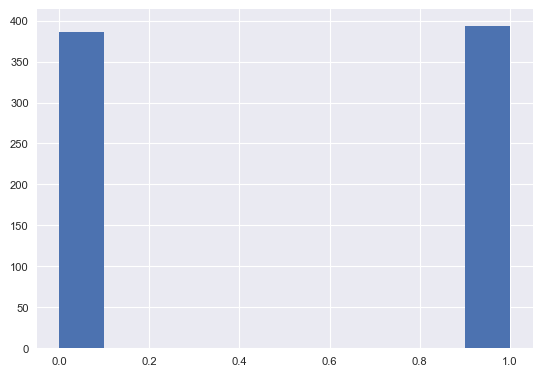

In [27]:
plt.hist(df_res['y_prob']);


# DELETEME BELOW

## Linear

In [28]:
# # psudocode

# ds_train, ds_val = train_test_split_ds(ds_known, test_size=0.3)
# X_val, y_val = ds2xy(ds_val)
# X_train, y_train = ds2xy(ds_train)
# # scale
# # fit
# # pred
# # proxy2label
# # score

# the only part that varies is the fit and pred, so maybe I just need to pass in cls!


In [29]:
# Here we look at the score for seeing which version is more truthfull, this is not that real label
from src.eval.interventions import check_lr_intervention_predictive2

r = check_lr_intervention_predictive2(X_train, y_train, X_val, y_val, verbose=False, proxy2label=proxy2label)


ImportError: cannot import name 'preproc' from 'src.probes.utils' (/media/wassname/SGIronWolf/projects5/elk/sgd_probes_are_lie_detectors/src/probes/utils.py)

In [ ]:
import copy
r2 = copy.deepcopy(r) # not sure where this is being modified in place, but this should stop it


In [ ]:
# unit test
y = label_fn(ds_known)
y2 = undo_ranked_truth_telling(y, ds_known)
y3 = ds_known['label_true_base']
np.testing.assert_array_equal(y2, y3, err_msg="we should be able to undo the label transform")


In [ ]:
# TODO clean this up somehow
# TODO, I need to split the ds or fs. That way I can undo the label easily
y_val_pred = torch.tensor(r2['y_val_pred']).clone()
y_val = torch.tensor(r2['y_val']).clone()
ds_known_val = ds_known.select(range(len(ds_known)-len(y_val_pred), len(ds_known)))
y_val_pred_true = undo_ranked_truth_telling(y_val_pred, ds=ds_known_val)
y_val2 = undo_ranked_truth_telling(y_val, ds=ds_known_val)

# just to make sure they match up
y_val3 = ds_known_val['label_true_base']
np.testing.assert_array_equal(y_val2, y_val3, err_msg="make sure we used the right dataset")

r = postproc(y_val_pred_true, y_val2, verbose=True)
# r = postproc(y_val_pred_true, y_val3, verbose=True)


# Conv mse ranking

In [ ]:
from src.helpers.torch_helpers import clear_mem, detachcpu, recursive_copy, switch

def distance_truth_telling(ds):
    """label whether the adapter or the base model were more truthfull."""
    return ds['correct_truth_telling_base'] - ds['correct_truth_telling_adapt']


def undo_distance_truth_telling(base_more_truthful: Float[Tensor, ''], ds: Dataset, ):
    #note if we know which model is more truthful, and it's a binary choice, we can take the choice that is in that direction as the truth
    base_more_positive = (ds['binary_ans_base'] > ds['binary_ans_adapt']) * 1.0
    return base_more_truthful * base_more_positive + (1-base_more_positive) * (-base_more_truthful)
    # return switch(base_more_positive, base_more_truthful)


y = distance_truth_telling(ds_known)
y2 = undo_distance_truth_telling(y, ds_known)
np.testing.assert_array_equal(y2>0, ds_known['label_true_base'], err_msg="we should be able to undo the label transform")


In [ ]:
# plt.hist(y, bins=20)
# plt.hist(y2, bins=20)
# plt.hist(ds_known['label_true_base']*1.0, bins=20)


In [ ]:
# def check_convrank_intervention_predictive(hs, y, verbose=True):

y = distance_truth_telling(ds_known)
X = torch.stack([hs_normal,hs_intervene], 1)
X_train0, X_val0, X_train1, X_val1, y_train, y_val = train_test_split(hs_normal, hs_intervene, y, test_size=0.5, random_state=42, shuffle=False)

to_ds = lambda hs0, hs1, y: TensorDataset(hs0, hs1, y)
dl_train = DataLoader(to_ds(X_train0, X_train1, y_train), batch_size=batch_size, shuffle=True)
dl_val = DataLoader(to_ds(X_val0, X_val1, y_val), batch_size=batch_size, shuffle=False)

x0, x1,y1 = next(iter(dl_train))
c_in = x1.shape[1:]
net = PLConvProbeLinear(c_in, epoch_steps=len(dl_train),  max_epochs=max_epochs, depth=3, lr=4e-3, weight_decay=1e-5, hs=32, dropout=0.1)

from torchinfo import summary
summary(net, input_data=x1) # input_size=(batch_size, 1, 28, 28))


trainer1 = pl.Trainer(
    gradient_clip_val=20,
    # accelerator="auto",
    # devices="1",
    max_epochs=max_epochs,
    log_every_n_steps=1,
    enable_progress_bar=verbose,
      enable_model_summary=verbose
)
trainer1.fit(model=net, train_dataloaders=dl_train, val_dataloaders=dl_val);

df_hist, df_hist_step  = read_metrics_csv(trainer1.logger.experiment.metrics_file_path)

df_hist[['val/acc', 'train/acc']].plot()
df_hist[['val/loss_epoch', 'train/loss_epoch']].plot()
# df_hist_step[['val/acc', 'train/acc']].plot(style=".")
# df_hist_step[['val/loss', 'train/loss']].plot(style=".")


In [ ]:

r = trainer1.predict(net, dataloaders=dl_val)
y_pred_raw = torch.cat(r).flatten()
# y_pred_prob = (y_pred_raw+1)/2
y_pred_prob = (torch.tanh(y_pred_raw)+1)/2
# y_val2 = y_val > 0.


# undo label transform...
ds_known_val = ds_known.select(range(len(ds_known)-len(y_pred_raw), len(ds_known)))
y_val_pred_true = undo_distance_truth_telling(y_pred_prob, ds=ds_known_val)

y_val3 = undo_distance_truth_telling(y_val, ds=ds_known_val)
y_val4 = ds_known_val['label_true_base']
np.testing.assert_array_equal(y_val3>0, y_val4, err_msg="make sure we used the right dataset")

y_pred = y_val_pred_true > 0.
y_val5 = y_val3 > 0.

score = roc_auc_score(y_val5, y_val_pred_true)
print(score)
target_names = [0, 1]
cm = confusion_matrix(y_val5, y_pred, target_names=target_names, normalize='true')
cr = classification_report(y_val5, y_pred, target_names=target_names)
print(cm)
print(cr)
# return score


In [ ]:
# hist_kwargs = dict(lw=2, alpha=0.75, histtype="step", bins=26, range=(-2,2))
# plt.hist(y_pred_prob, label='prob', **hist_kwargs, )
# plt.hist(y_val2,label='pred',  **hist_kwargs,)
# plt.hist(y_pred, label='truth',  **hist_kwargs,)
# plt.legend()
# plt.show()

# plt.hist(y_pred_raw, label='pred',  **hist_kwargs,)
# plt.hist(y_val,  label='truth',  **hist_kwargs,)
# plt.legend()
# plt.show()


# Conv bool ranking

In [ ]:
from torchmetrics.functional import accuracy, auroc, f1_score, jaccard_index, dice
from random import random as rand

class PLConvProbeBoolRank(PLConvProbeLinear):
    def _step(self, batch, batch_idx, stage='train'):
        x0, x1, y = batch

        # if rand()>0.5:
        #     x0, x1 = x1, x0
        #     y = 1-y
            
        ypred0 = self(x0)
        ypred1 = self(x1)
        
        if stage=='pred':
            return (ypred1-ypred0).float()
        
        ranking_y = (y>0)*2-1 # from 0,1 to -1,1
        loss = F.margin_ranking_loss(ypred1, ypred0, ranking_y, margin=1)
        # loss = F.smooth_l1_loss(ypred1-ypred0, y)
        # self.log(f"{stage}/loss", loss)
        
        y_cls = ypred1>ypred0 # switch2bool(ypred1-ypred0)
        self.log(f"{stage}/acc", accuracy(y_cls, y>0, "binary"), on_epoch=True, on_step=False)
        self.log(f"{stage}/loss", loss, on_epoch=True, on_step=False)
        self.log(f"{stage}/n", len(y), on_epoch=True, on_step=False, reduce_fx=torch.sum)
        return loss


In [ ]:


# def check_convrank_intervention_predictive(hs, y, verbose=True):


def dist_truth_telling(ds):
    """label whether the adapter or the base model were more truthfull."""
    return ds['correct_truth_telling_adapt'] > ds['correct_truth_telling_base']

y = dist_truth_telling(ds_known)
X = torch.stack([hs_normal,hs_intervene], 1)
X_train0, X_val0, X_train1, X_val1, y_train, y_val = train_test_split(hs_normal, hs_intervene, y, test_size=0.5, random_state=42)

to_ds = lambda hs0, hs1, y: TensorDataset(hs0, hs1, y)
dl_train = DataLoader(to_ds(X_train0, X_train1, y_train), batch_size=batch_size, shuffle=True)
dl_val = DataLoader(to_ds(X_val0, X_val1, y_val), batch_size=batch_size, shuffle=False)

x0, x1,y1 = next(iter(dl_train))
c_in = x1.shape[1:]
net = PLConvProbeBoolRank(c_in, epoch_steps=len(dl_train),  max_epochs=max_epochs, depth=3, lr=4e-3, weight_decay=1e-5, hs=16, dropout=0.2)

from torchinfo import summary
summary(net, input_data=x1) # input_size=(batch_size, 1, 28, 28))


trainer1 = pl.Trainer(
    gradient_clip_val=20,
    # accelerator="auto",
    # devices="1",
    max_epochs=max_epochs,
    log_every_n_steps=1,
    enable_progress_bar=verbose,
      enable_model_summary=verbose
)
trainer1.fit(model=net, train_dataloaders=dl_train, val_dataloaders=dl_val);



df_hist, df_hist_step  = read_metrics_csv(trainer1.logger.experiment.metrics_file_path)

df_hist[['val/acc', 'train/acc']].plot()
df_hist[['val/loss', 'train/loss']].plot()
# df_hist_step[['val/acc', 'train/acc']].plot(style=".")
# df_hist_step[['val/loss', 'train/loss']].plot(style=".")


In [ ]:
r = trainer1.predict(net, dataloaders=dl_val)
y_pred_raw = torch.cat(r).flatten()
y_pred_prob = (torch.tanh(y_pred_raw)+1)/2
# y_pred = y_pred_raw > 0.
y_val2 = y_val > 0.



# undo label transform...
ds_known_val = ds_known.select(range(len(ds_known)-len(y_pred_raw), len(ds_known)))
y_val_pred_true = undo_ranked_truth_telling(y_pred_prob, ds=ds_known_val)
y_val3 = undo_ranked_truth_telling(y_val2, ds=ds_known_val)

y_pred = y_val_pred_true > 0.5

score = roc_auc_score(y_val3, y_val_pred_true)
print(score)
target_names = [0, 1]
cm = confusion_matrix(y_val3, y_pred, target_names=target_names, normalize='true')
cr = classification_report(y_val3, y_pred, target_names=target_names)
print(cm)
print(cr)

# return score


In [ ]:
# DEBUG dist
hist_kwargs = dict(lw=2, alpha=0.75, histtype="step", bins=26, range=(-2,2))
plt.hist(y_pred_prob, label='prob', **hist_kwargs, )
plt.hist(y_val2,label='pred',  **hist_kwargs,)
plt.hist(y_pred, label='truth',  **hist_kwargs,)
plt.legend()
plt.show()

plt.hist(y_pred_raw, label='pred',  **hist_kwargs,)
plt.hist(y_val,  label='truth',  **hist_kwargs,)
plt.legend()
plt.show()


# Conv direct


In [ ]:
from torchmetrics.functional import accuracy, auroc, f1_score, jaccard_index, dice
from src.probes.pl_ranking_probe import LinBnDrop, InceptionBlock, PLRankingBase

class PLConvProbeLinearCls(PLRankingBase):

    def __init__(self, c_in, epoch_steps, max_epochs, depth=0, lr=4e-3, weight_decay=1e-9, hs=8, dropout=0, **kwargs):
        super().__init__(epoch_steps=epoch_steps, max_epochs=max_epochs, lr=lr, weight_decay=weight_decay)
        self.save_hyperparameters()
        
        self.pre = nn.Sequential(
            # nn.BatchNorm2d(c_in[1], affine=False),
            nn.Conv2d(c_in[1], hs*4, (1, 2)),
            nn.Conv2d(hs*4, hs*4, (2, 1)),
        )

        layers = [
            nn.BatchNorm1d(hs*4, affine=False)
            ]
        for i in range(depth+1):
            if (i>0) and (i<depth):
                layers.append(InceptionBlock(hs*4, hs, conv_dropout=dropout))
            elif i==0: # first layer
                if depth==0: 
                    layers.append(InceptionBlock(hs*4, 1))
                else:
                    layers.append(InceptionBlock(hs*4, hs, conv_dropout=dropout))
            else: # last layer
                layers.append(nn.Conv1d(hs*4, 1, 1))
        self.conv = nn.Sequential(*layers)
        
        n = c_in[0] - 1
        self.head = nn.Sequential(
            LinBnDrop(n, n, p=dropout),
            LinBnDrop(n, n, p=dropout),
            nn.Linear(n, 1),  
            # nn.Tanh(), 
        )
        
    def forward(self, x):
        if x.ndim==4:
            x = x.squeeze(3)
        x = rearrange(x, 'b l h n -> b h l n')
        x = self.pre(x)
        x = rearrange(x, 'b h l n -> b h (l n)')
        x = self.conv(x)
        x = rearrange(x, 'b l h -> b (l h)')
        return self.head(x).squeeze(1)
    
    def _step(self, batch, batch_idx, stage='train'):
        x0, y = batch
        logits = self(x0)
        ypred = torch.sigmoid(logits)
        
        if stage=='pred':
            return ypred.float()
        
        loss = F.binary_cross_entropy_with_logits(logits, y.float())
        
        self.log(f"{stage}/acc", accuracy(ypred, y, "binary"), on_epoch=True, )
        self.log(f"{stage}/loss", loss, on_epoch=True,  prog_bar=True)
        self.log(f"{stage}/n", len(y), on_epoch=True, on_step=False, reduce_fx=torch.sum)
        return loss


In [ ]:

y = ds2label_model_truth(ds_known)
y = ranking_truth_telling(ds_known)
X = torch.stack([hs_normal,hs_intervene], 3)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.5, random_state=42)
X_train.shape


In [ ]:

to_ds = lambda hs, y: TensorDataset(hs, y)
dl_train = DataLoader(to_ds(X_train, y_train), batch_size=batch_size, shuffle=True)
dl_val = DataLoader(to_ds(X_val, y_val), batch_size=batch_size, shuffle=False)

x1,y1 = next(iter(dl_train))
c_in = x1.shape[1:]
print(c_in)
net = PLConvProbeLinearCls(c_in, epoch_steps=len(dl_train),  max_epochs=max_epochs, depth=2, lr=4e-3, weight_decay=1e-5, hs=16, dropout=0.2)
# print(net)


In [ ]:
from torchinfo import summary
summary(net, input_data=x1) # input_size=(batch_size, 1, 28, 28))


In [ ]:
# print(c_in)
# with torch.no_grad():
#     net(x1)


In [ ]:




trainer1 = pl.Trainer(
    gradient_clip_val=20,
    # accelerator="auto",
    # devices="1",
    max_epochs=max_epochs,
    log_every_n_steps=1,
    enable_progress_bar=verbose, enable_model_summary=verbose
)
trainer1.fit(model=net, train_dataloaders=dl_train, val_dataloaders=dl_val);



df_hist, df_hist_step  = read_metrics_csv(trainer1.logger.experiment.metrics_file_path)

df_hist[['val/acc', 'train/acc']].plot()
# df_hist[['val/loss', 'train/loss']].plot()
# df_hist_step[['val/acc', 'train/acc']].plot(style=".")
# df_hist_step[['val/loss', 'train/loss']].plot(style=".")


In [ ]:
r = trainer1.predict(net, dataloaders=dl_val)
y_pred_prob = torch.cat(r).flatten()
y_pred = y_pred_prob > 0.5

score = roc_auc_score(y_val, y_pred_prob)

print(score)
target_names = [0, 1]
cm = confusion_matrix(y_val, y_pred, target_names=target_names, normalize='true')
cr = classification_report(y_val, y_pred, target_names=target_names)
print(cm)
print(cr)

# return score


In [ ]:
# # DEBUG DIST
# hist_kwargs = dict(lw=2, alpha=0.75, histtype="step", bins=26, range=(-2,2))
# plt.hist(y_pred_prob, label='prob', **hist_kwargs, )
# plt.hist(y_val2,label='pred',  **hist_kwargs,)
# plt.hist(y_pred, label='truth',  **hist_kwargs,)
# plt.legend()
# plt.show()

# plt.hist(y_pred_raw, label='pred',  **hist_kwargs,)
# plt.hist(y_val,  label='truth',  **hist_kwargs,)
# plt.legend()
# plt.show()


# CCS

In [ ]:
import torch as t

def ccs_loss(p_neg, p_pos):
    consistency_losses = (p_pos - (1 - p_neg)) ** 2
    confidence_losses = t.min(t.stack((p_pos, p_neg), dim=-1), dim=-1).values ** 2
    return t.mean(consistency_losses + confidence_losses)

class PL_CSS(PLRankingBase):
    def __init__(self, d_in, epoch_steps: int, max_epochs: int, lr=4e-3, weight_decay=1e-9):
        super().__init__(epoch_steps=epoch_steps, max_epochs=max_epochs, lr=lr, weight_decay=weight_decay)
        self.model = t.nn.Sequential(
            t.nn.Linear(d_in, 1, bias=False),
            t.nn.Sigmoid()
        )
        self.total_steps = epoch_steps * max_epochs
        self.save_hyperparameters()

    def forward(self, x):
        return self.model(x.squeeze(2))
        
    def _step(self, batch, batch_idx, stage='train'):
        h, y = batch
        yb = y>0.5
        ypred = self(h)
        if stage=='pred':
            return ypred
        p_neg = ypred[~yb].mean()
        p_pos = ypred[yb].mean()
        loss = ccs_loss(p_neg, p_pos)
        assert torch.isfinite(loss)
        
        y_cls = ypred>0.5 # switch2bool(ypred1-ypred0)
        self.log(f"{stage}/acc", accuracy(y_cls, y>0, "binary"), on_epoch=True, on_step=False)
        self.log(f"{stage}/loss", loss, on_epoch=True, on_step=True, prog_bar=True)
        self.log(f"{stage}/n", len(y), on_epoch=True, on_step=False, reduce_fx=torch.sum)
        return loss


In [ ]:
hs_normal = ds_known['end_residual_stream_base']
hs_intervene = ds_known['end_residual_stream_adapt']
label_fn = ranking_truth_telling
hs = hs_normal - hs_intervene
y = label_fn(ds_known)


In [ ]:
to_ds = lambda hs, y: TensorDataset(hs, y)
dl_train = DataLoader(to_ds(X_train, y_train), batch_size=128, shuffle=True)
dl_val = DataLoader(to_ds(X_val, y_val), batch_size=128, shuffle=False)
x, y = next(iter(dl_train))
c_in = x.shape[1]

net = PL_CSS(d_in=c_in, epoch_steps=len(dl_train),  max_epochs=max_epochs, lr=4e-4, 
             weight_decay=1e-5)
trainer = pl.Trainer(
    # gradient_clip_val=20,
    # accelerator="auto",
    # devices="1",
    max_epochs=max_epochs,
    log_every_n_steps=1,
    enable_progress_bar=verbose, enable_model_summary=verbose
)
trainer.fit(model=net, train_dataloaders=dl_train, val_dataloaders=dl_val);


df_hist, df_hist_step  = read_metrics_csv(trainer.logger.experiment.metrics_file_path)

df_hist[['val/acc', 'train/acc']].plot()
df_hist[['val/loss_epoch', 'train/loss_epoch']].plot()


In [ ]:
r = trainer1.predict(net, dataloaders=dl_val)
y_pred_prob = torch.cat(r).flatten()
y_pred = y_pred_prob > 0.5

score = roc_auc_score(y_val, y_pred_prob)

print(score)
target_names = [0, 1]
cm = confusion_matrix(y_val, y_pred, target_names=target_names, normalize='true')
cr = classification_report(y_val, y_pred, target_names=target_names)
print(cm)
print(cr)

# return score


# Conformal

In [ ]:

import numpy as np
from sklearn.naive_bayes import GaussianNB, BernoulliNB, ComplementNB, MultinomialNB
from mapie.classification import MapieClassifier

layers = X.shape[1]
X = rearrange(hs, 'b l hs -> b (l hs)')
X_train, X_val, y_train, y_val = preproc(X, y)


In [ ]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(random_state=42, max_iter=1000, class_weight='balanced',).fit(X_train, y_train)
mapie = MapieClassifier(estimator=clf, cv="prefit",
                        # method="score",                        
                        ).fit(X_train, y_train)
y_val_prob, y_val_pred = mapie.predict(X_val, alpha=0.2)
r = postproc(y_val_prob, y_val)

